In [36]:
# This is the new version of thesis coding
# My code is partly inspired from https://github.com/mrdragonbear/EchoStateNetworks and https://github.com/cknd/pyESN, 
# and they are under MIT license.

In [37]:
# import packages
from my_ESN import ESN
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import random
import networkx as nx
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

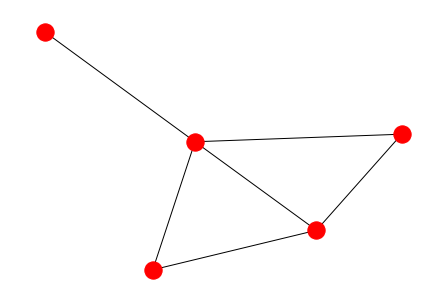

In [38]:
# A sample network
sampleG = nx.Graph()
sampleG.add_edge(1,2)
sampleG.add_edge(1,3)
sampleG.add_edge(2,3)
sampleG.add_edge(2,4)
sampleG.add_edge(3,4)
sampleG.add_edge(3,5)
nx.draw(sampleG, node_color="red")
plt.savefig("sample_network")
plt.show()

In [39]:
# data preprocessing 
data = pd.read_csv("257_2019-02-01.csv",header=None, index_col=[0])
data.index = pd.to_datetime(data.index) # string index to time index

random.seed(50) # set the seed to select the first day's data of training set 
train_day_1 = random.randint(1,28)
print(train_day_1) # use Feb 16, 17, 18 to train
train_day_2 = train_day_1+1
train_day_3 = train_day_1+2
test_day = train_day_1+3 # Feb 19 data as test data

train_data_1 = data["2019-02-"+str(train_day_1)][1]
train_data_2 = data["2019-02-"+str(train_day_2)][1]
train_data_3 = data["2019-02-"+str(train_day_3)][1]
test_data = data["2019-02-"+str(test_day)][1]

train_ts_1 = train_data_1.to_numpy()
train_ts_2 = train_data_2.to_numpy()
train_ts_3 = train_data_3.to_numpy()
test_ts = test_data.to_numpy()

train_ts = np.hstack((train_ts_1, train_ts_2, train_ts_3))
# total_ts = np.hstack((train_ts, test_ts)) # total_ms for machine learning



16


C:\Users\alber\AppData\Local\Temp\ipykernel_28120\868642982.py:12: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  train_data_1 = data["2019-02-"+str(train_day_1)][1]
C:\Users\alber\AppData\Local\Temp\ipykernel_28120\868642982.py:13: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  train_data_2 = data["2019-02-"+str(train_day_2)][1]
C:\Users\alber\AppData\Local\Temp\ipykernel_28120\868642982.py:14: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  train_data_3 = data["2019-02-"+str(train_day_3)][1

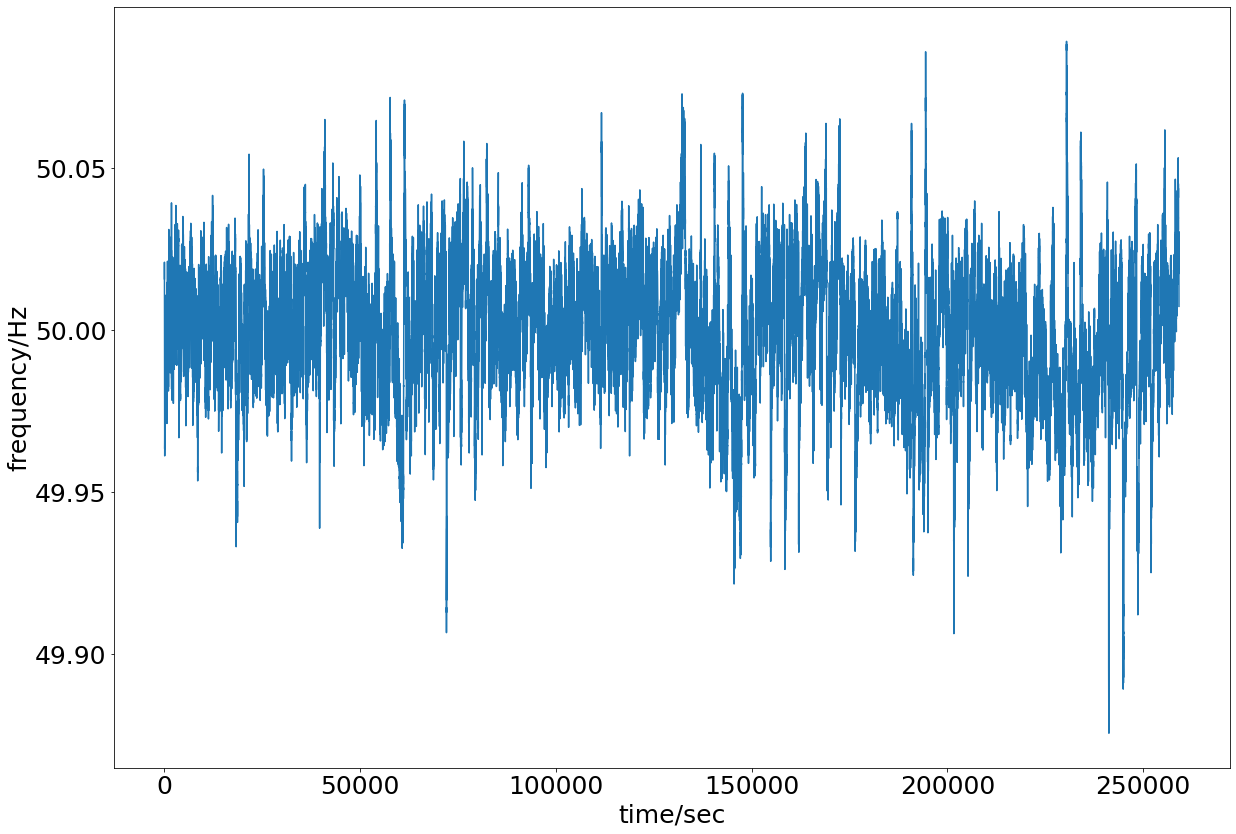

In [40]:
# plot the training data

plt.rcParams["figure.figsize"] = (20,14)
plt.plot(train_ts)
plt.xlabel("time/sec", fontsize = 25)
plt.ylabel("frequency/Hz", fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.savefig("training_time_series")
plt.show()

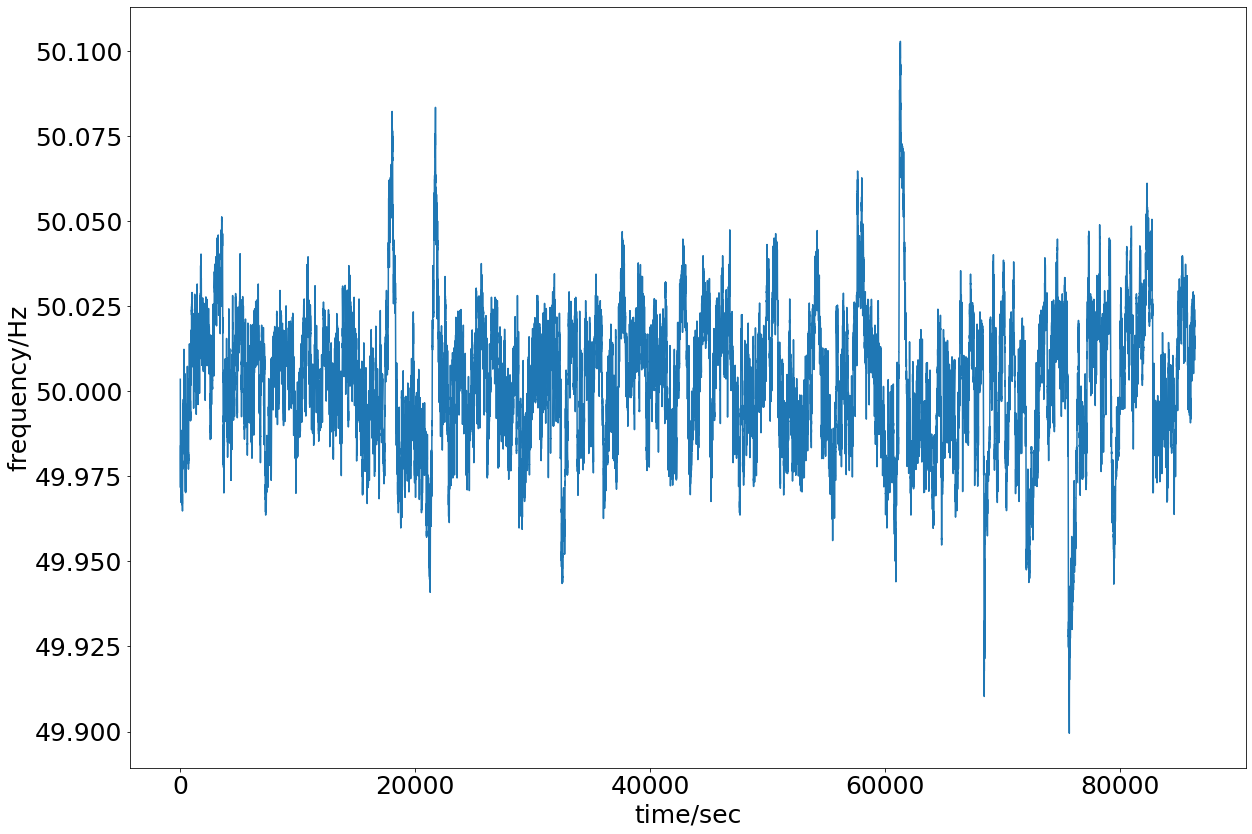

In [41]:
# plot the test data
plt.plot(test_ts)
plt.xlabel("time/sec", fontsize = 25)
plt.ylabel("frequency/Hz", fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.rcParams["figure.figsize"] = (20,14)
plt.savefig("test_time_series")
plt.show()

In [42]:
# perform the augmented Dickey-Fuller test for training data 
from statsmodels.tsa.stattools import adfuller
adf = adfuller(train_ts)
print("test statistic is", adf[0])
print("p-value is", adf[1])
print("critical values are")
print(adf[4])
# stationary

test statistic is -18.041470343243557
p-value is 2.6568951566494126e-30
critical values are
{'1%': -3.4303752375991228, '5%': -2.861551154698899, '10%': -2.56677593724274}


In [43]:
# set up power grid network
nodes = pd.read_excel("nodes.xlsx")
links = pd.read_excel("links.xlsx")

# generate a node list and a link list
nodeslist = []
for i in range(0, len(nodes)):
    nodeslist.append(nodes.iloc[i]["v_id"])
linkslist = []
for i in range(0, len(links)):
    linkslist.append([links.iloc[i]["v_id_1"], links.iloc[i]["v_id_2"]])
    
# generate the power gird network; plotting with position was done with the coding of advanced project 2
network = nx.Graph()# normal graph
network.add_nodes_from(nodeslist)
network.add_edges_from(linkslist)

# mutligraph
m_network = nx.MultiGraph()
m_network.add_nodes_from(nodeslist)
m_network.add_edges_from(linkslist)

print(nx.number_of_nodes(network))
print(nx.number_of_edges(network))
print(nx.number_of_edges(m_network))

511
679
836


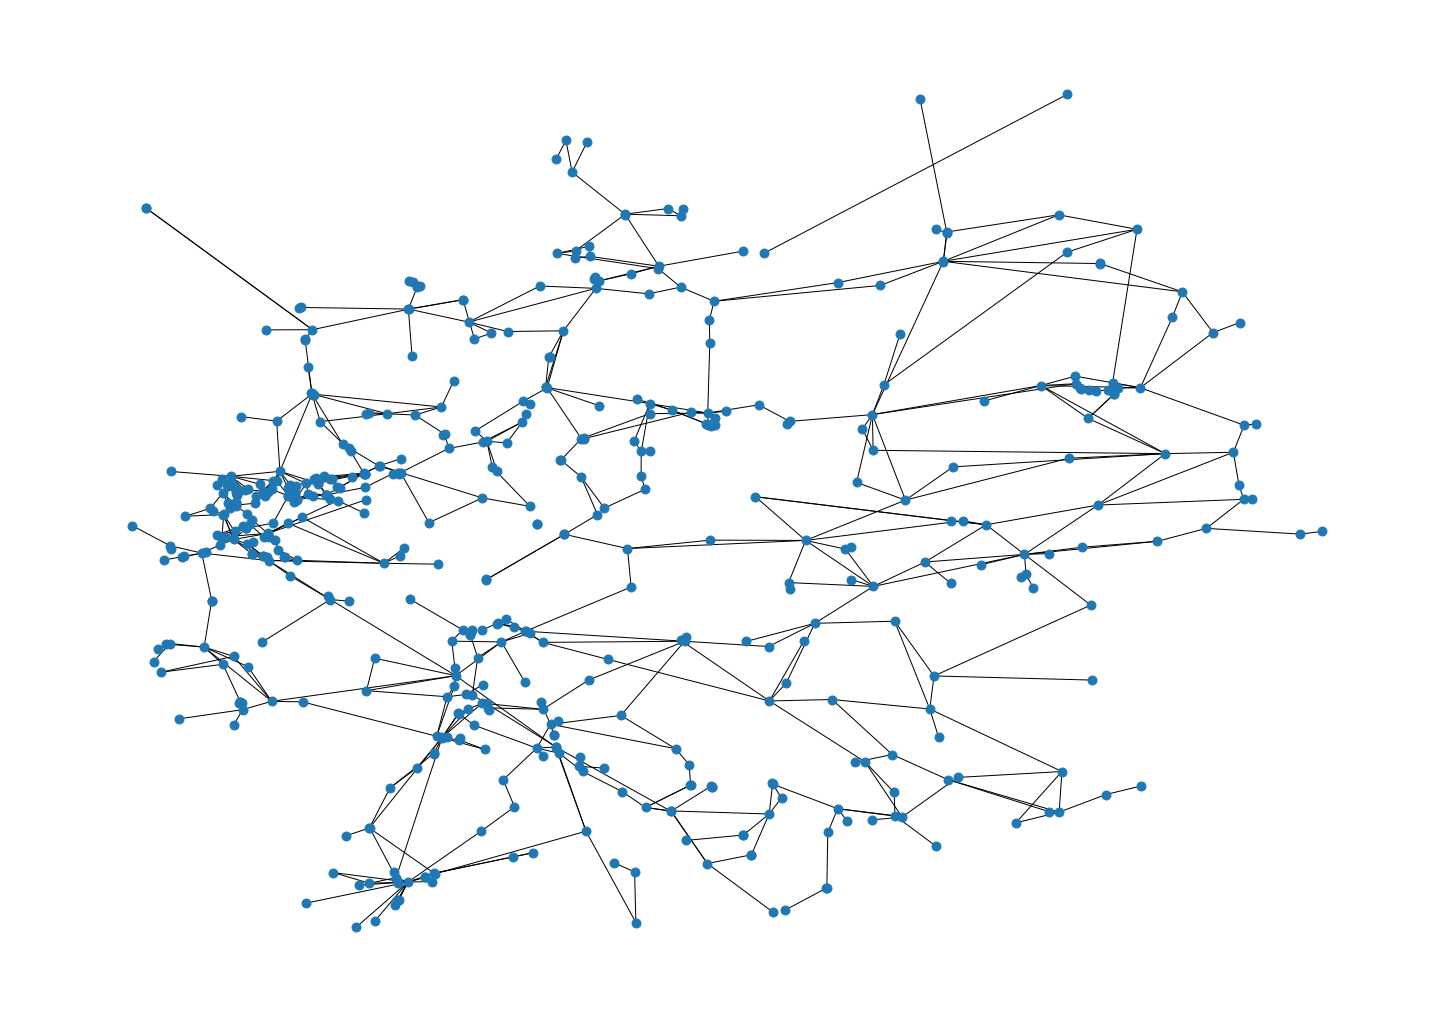

In [44]:
# power grid network position plotting
posdict = {}
for i in range(0, len(nodes)):
    posdict[nodes.iloc[i]["v_id"]] = (nodes.iloc[i]["lon"], nodes.iloc[i]["lat"])

nx.draw(network, posdict, node_size = 80)
plt.savefig("power grid network with node positions")
plt.show()

In [45]:
# ML parts start from here
# no teacher forcing
# no prediction window

rand_seed=46
spectral_radius = 0.8
noise = .005
A = nx.to_numpy_array(network) # adjacency matrix of the power grid network
total_ts = np.hstack((train_ts, test_ts[:1000])) # total_ts for machine learning


esn = ESN(input_dim = 1,
      output_dim = 1, 
      adjacency_matrix = A,
      random_state=rand_seed,
      spectral_radius = spectral_radius,
      noise=noise,
      print_performance = False,
      feedback=False) # no feedback

trainlen = len(train_ts) # training data length
futureTotal = 1000 # 1000 data point prediction

pred_training = esn.fit(np.ones(trainlen),total_ts[:trainlen])
prediction = esn.predict(np.ones(futureTotal))



In [46]:
# print out the MSE and R2
MSE = mean_squared_error(total_ts[trainlen:trainlen+futureTotal], prediction.flatten())
print("MSE:", MSE)
R2 = r2_score(total_ts[trainlen:trainlen+futureTotal], prediction.flatten())
print("R2:", R2)

MSE: 0.0002634484621127662
R2: -0.35718520936176157


In [47]:
# does less prediction length leads to better R2? 
test_length_list_1 = np.arange(1, 101, 1) 
R2_list = []
for i in test_length_list_1:
    rand_seed=46
    spectral_radius = 0.8
    noise = .005
    A = nx.to_numpy_array(network) # adjacency matrix of the power grid network
    total_ts = np.hstack((train_ts, test_ts[:i])) # total_ts for machine learning


    esn = ESN(input_dim = 1,
          output_dim = 1, 
          adjacency_matrix = A,
          random_state=rand_seed,
          spectral_radius = spectral_radius,
          noise=noise,
          print_performance = False,
          feedback=False) # no feedback

    trainlen = len(train_ts) # training data length
    futureTotal = i # i data point prediction

    pred_training = esn.fit(np.ones(trainlen),total_ts[:trainlen])
    prediction = esn.predict(np.ones(futureTotal))
    # print out the MSE and R2
    print("prediction data length is", i)
    MSE = mean_squared_error(total_ts[trainlen:trainlen+futureTotal], prediction.flatten())
    print("MSE:", MSE)
    R2 = r2_score(total_ts[trainlen:trainlen+futureTotal], prediction.flatten())
    print("R2:", R2)
    
    R2_list.append(R2)

prediction data length is 1
MSE: 2.6686564952033724e-05
R2: nan


D:\anaconda\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


prediction data length is 2
MSE: 1.675950589066567e-05
R2: -19.690748013100585
prediction data length is 3
MSE: 1.1436132518809196e-05
R2: -5.666139421586066
prediction data length is 4
MSE: 9.226328455867843e-06
R2: -1.3657252450937083
prediction data length is 5
MSE: 9.015999173360414e-06
R2: -0.4500770672528258
prediction data length is 6
MSE: 9.845729489294935e-06
R2: -0.15244590198466246
prediction data length is 7
MSE: 1.5097608396538462e-05
R2: -0.25501783230455755
prediction data length is 8
MSE: 2.2563500832349145e-05
R2: -0.17411218068700607
prediction data length is 9
MSE: 3.485840203005795e-05
R2: -0.30252270310748886
prediction data length is 10
MSE: 5.101188540094524e-05
R2: -0.46674809729273004
prediction data length is 11
MSE: 7.573023154896076e-05
R2: -0.7077465293680085
prediction data length is 12
MSE: 0.0001002680457236031
R2: -0.7624209743810066
prediction data length is 13
MSE: 0.00012494146083786366
R2: -0.774945518871121
prediction data length is 14
MSE: 0.00016

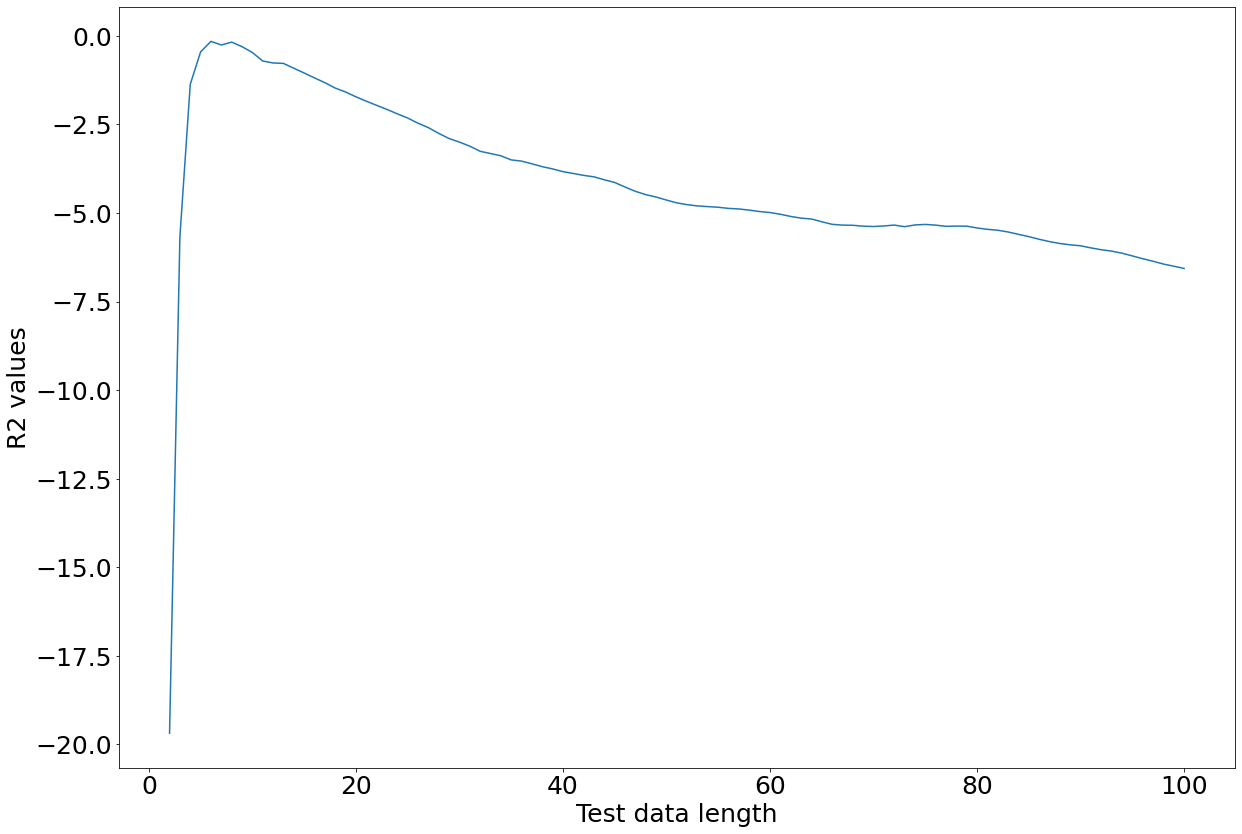

In [48]:
plt.plot(test_length_list_1[1:], R2_list[1:])
plt.xlabel("Test data length",fontsize = 25)
plt.ylabel("R2 values", fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.savefig("Length_vs_R2")
plt.show()

In [49]:
# maximum R2
print("maximum R2 is",np.max(R2_list[1:]), "with the prediction data length", test_length_list_1[np.argmax(R2_list[1:])] )

maximum R2 is -0.15244590198466246 with the prediction data length 5


In [50]:
R2

-6.566276383740721

In [51]:
test_length_list_1[99]

100

In [52]:
R2_list[99]

-6.566276383740721

In [53]:
futureTotal

100

In [54]:
# plot the result of prediction length = 5
rand_seed=46
spectral_radius = 0.8
noise = .005
A = nx.to_numpy_array(network) # adjacency matrix of the power grid network
total_ts = np.hstack((train_ts, test_ts[:5])) # total_ts for machine learning


esn = ESN(input_dim = 1,
      output_dim = 1, 
      adjacency_matrix = A,
      random_state=rand_seed,
      spectral_radius = spectral_radius,
      noise=noise,
      print_performance = False,
      feedback=False) # no feedback

trainlen = len(train_ts) # training data length
futureTotal = 5 # 5 data point prediction

pred_training = esn.fit(np.ones(trainlen),total_ts[:trainlen])
prediction = esn.predict(np.ones(futureTotal))





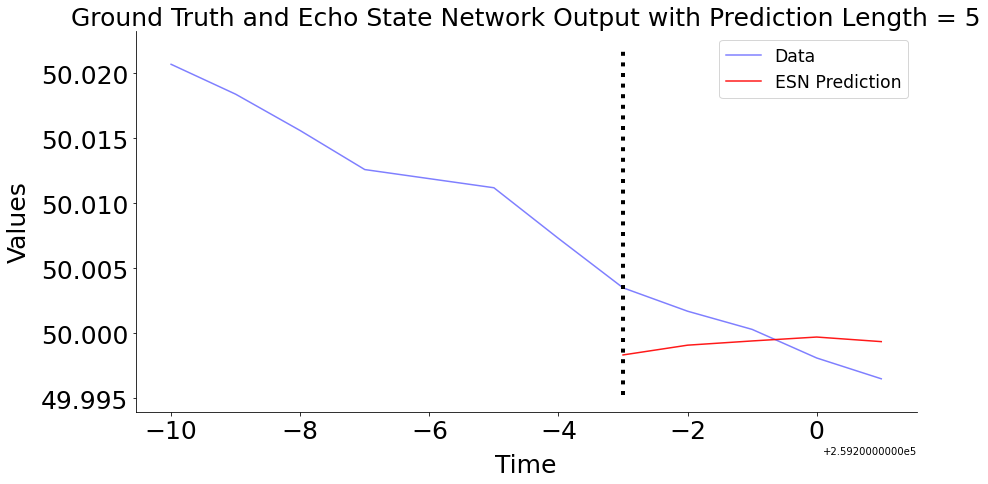

In [55]:
import seaborn as sns
from matplotlib import rc
rc('text', usetex=False)

plt.figure(figsize=(14,7))
plt.plot(range(259190,trainlen+futureTotal),total_ts[259190:trainlen+futureTotal],'b',label="Data", alpha=0.5)
plt.plot(range(trainlen,trainlen+futureTotal),prediction,'r',  alpha=0.9, label='ESN Prediction')

lo,hi = plt.ylim()
plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'k:', linewidth=4)

plt.title(r'Ground Truth and Echo State Network Output with Prediction Length = 5', fontsize=25)
plt.xlabel(r'Time', fontsize=25,labelpad=10)
plt.ylabel(r'Values', fontsize=25,labelpad=10)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.legend(fontsize='xx-large', loc='best')
sns.despine()
plt.savefig("result_1")


In [56]:
np.arange(1000, 10001, 500) 

array([ 1000,  1500,  2000,  2500,  3000,  3500,  4000,  4500,  5000,
        5500,  6000,  6500,  7000,  7500,  8000,  8500,  9000,  9500,
       10000])

In [57]:
# higher test data length
test_length_list_2 = np.arange(1000, 10001, 500) 
R2_list_2 = []
for i in test_length_list_2:
    rand_seed=46
    spectral_radius = 0.8
    noise = .005
    A = nx.to_numpy_array(network) # adjacency matrix of the power grid network
    total_ts = np.hstack((train_ts, test_ts[:i])) # total_ts for machine learning


    esn = ESN(input_dim = 1,
          output_dim = 1, 
          adjacency_matrix = A,
          random_state=rand_seed,
          spectral_radius = spectral_radius,
          noise=noise,
          print_performance = False,
          feedback=False) # no feedback

    trainlen = len(train_ts) # training data length
    futureTotal = i # i data point prediction

    pred_training = esn.fit(np.ones(trainlen),total_ts[:trainlen])
    prediction = esn.predict(np.ones(futureTotal))
    # print out the MSE and R2
    print("prediction data length is", i)
    MSE = mean_squared_error(total_ts[trainlen:trainlen+futureTotal], prediction.flatten())
    print("MSE:", MSE)
    R2 = r2_score(total_ts[trainlen:trainlen+futureTotal], prediction.flatten())
    print("R2:", R2)
    
    R2_list_2.append(R2)

prediction data length is 1000
MSE: 0.0002634484621127662
R2: -0.35718520936176157
prediction data length is 1500
MSE: 0.0002500686654380183
R2: -0.01450394476438488
prediction data length is 2000
MSE: 0.0002874857677418833
R2: -0.05207233666128963
prediction data length is 2500
MSE: 0.0002969946019892959
R2: -0.16211245161112475
prediction data length is 3000
MSE: 0.00029802969441772916
R2: -0.22196181936608572
prediction data length is 3500
MSE: 0.0004177113808803016
R2: -0.41213776811247316
prediction data length is 4000
MSE: 0.0004267059612492377
R2: -0.3508805341921455
prediction data length is 4500
MSE: 0.00039420428881441015
R2: -0.2761816521629823
prediction data length is 5000
MSE: 0.00037495210819495507
R2: -0.3106987781305466
prediction data length is 5500
MSE: 0.0003746858660292859
R2: -0.3661791540116248
prediction data length is 6000
MSE: 0.00034945375861462723
R2: -0.33925520780335194
prediction data length is 6500
MSE: 0.00033787489316782583
R2: -0.3417519061153589
pred

In [58]:
# maximum R2
print("maximum R2 is",np.max(R2_list_2[:]), "with the prediction data length", test_length_list_2[np.argmax(R2_list_2[:])] )

maximum R2 is -0.01450394476438488 with the prediction data length 1500


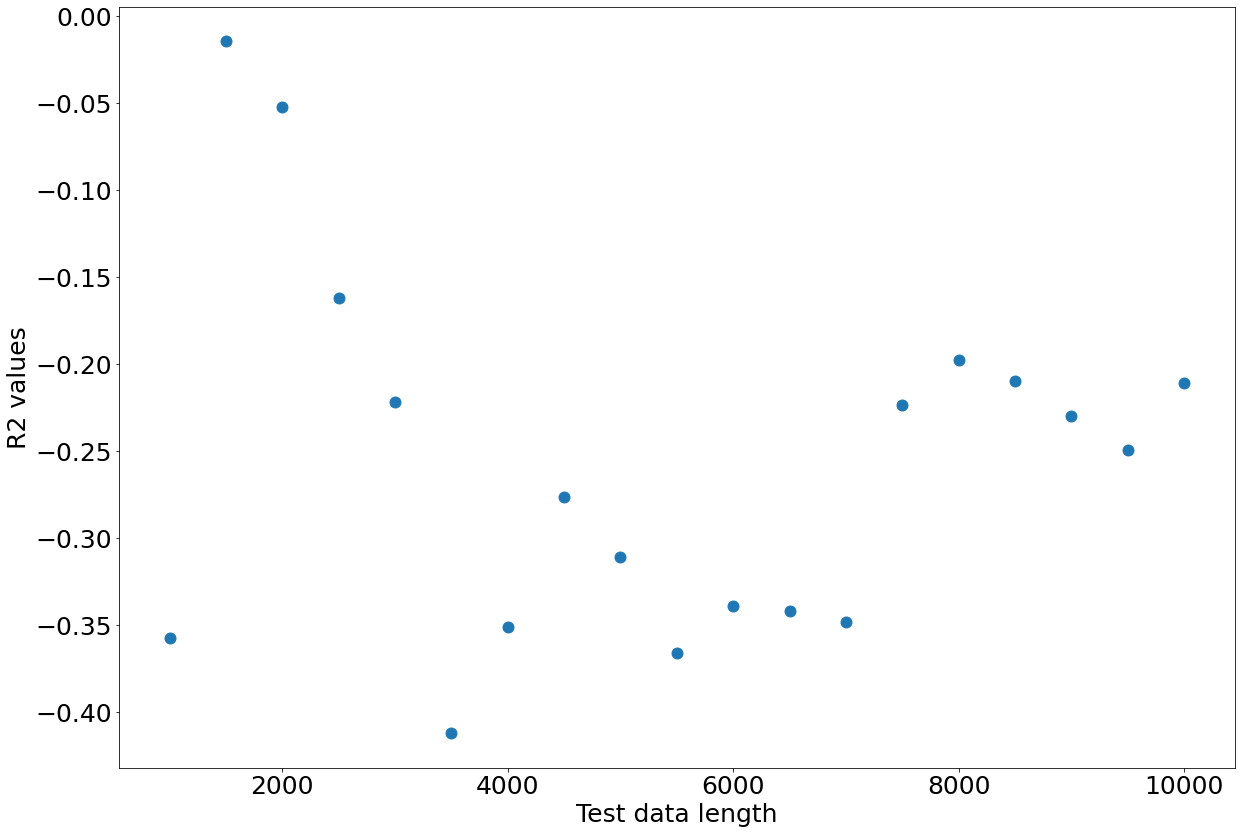

In [59]:
plt.scatter(test_length_list_2, R2_list_2, s = 120)
plt.xlabel("Test data length",fontsize=25)
plt.ylabel("R2 values",fontsize=25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.savefig("Length_vs_R2_2")
plt.show()

In [60]:
# plot the result of prediction length = 1500
rand_seed=46
spectral_radius = 0.8
noise = .005
A = nx.to_numpy_array(network) # adjacency matrix of the power grid network
total_ts = np.hstack((train_ts, test_ts[:1500])) # total_ts for machine learning


esn = ESN(input_dim = 1,
      output_dim = 1, 
      adjacency_matrix = A,
      random_state=rand_seed,
      spectral_radius = spectral_radius,
      noise=noise,
      print_performance = False,
      feedback=False) # no feedback

trainlen = len(train_ts) # training data length
futureTotal = 1500 # 1500 data point prediction

pred_training = esn.fit(np.ones(trainlen),total_ts[:trainlen])
prediction = esn.predict(np.ones(futureTotal))



In [61]:
MSE = mean_squared_error(total_ts[trainlen:trainlen+futureTotal], prediction.flatten())
print("MSE:", MSE)
R2 = r2_score(total_ts[trainlen:trainlen+futureTotal], prediction.flatten())
print("R2:", R2)

MSE: 0.0002500686654380183
R2: -0.01450394476438488


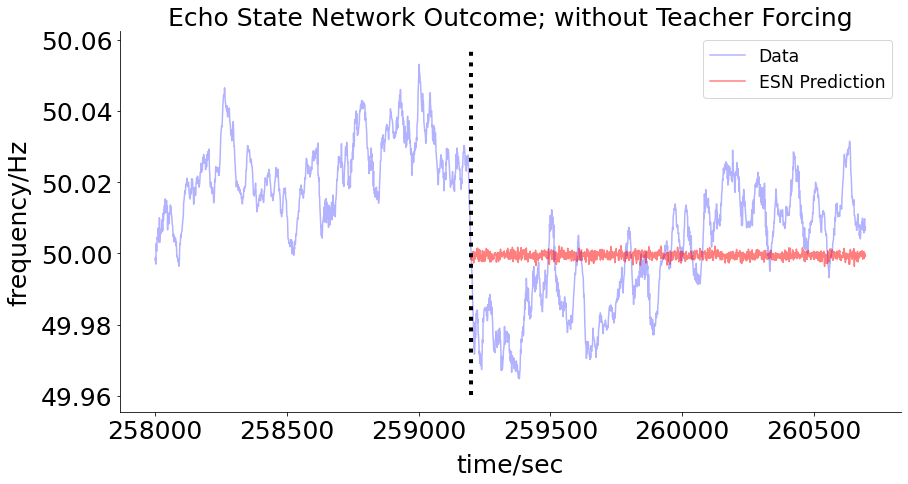

In [62]:
# plot the result
plt.figure(figsize=(14,7))
plt.plot(range(258000,trainlen+futureTotal),total_ts[258000:trainlen+futureTotal],'b', alpha=0.3, label="Data")
plt.plot(range(trainlen,trainlen+futureTotal),prediction,'r',  alpha=0.5, label='ESN Prediction')

lo,hi = plt.ylim()
plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'k:', linewidth=4)

plt.title(r'Echo State Network Outcome; without Teacher Forcing', fontsize=25)
plt.xlabel(r'time/sec', fontsize=25,labelpad=10)
plt.ylabel(r'frequency/Hz', fontsize=25,labelpad=10)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.legend(fontsize='xx-large', loc='best')
sns.despine()
plt.savefig("result_2")

In [63]:
# length = 1500 with teacher forcing
rand_seed=46
spectral_radius = 0.8
noise = .005
A = nx.to_numpy_array(network) # adjacency matrix of the power grid network
total_ts = np.hstack((train_ts, test_ts[:1500])) # total_ts for machine learning


esn = ESN(input_dim = 1,
      output_dim = 1, 
      adjacency_matrix = A,
      random_state=rand_seed,
      spectral_radius = spectral_radius,
      noise=noise,
      print_performance = False,
      feedback=True) # with feedback

trainlen = len(train_ts) # training data length
futureTotal = 1500 # 1500 data point prediction

pred_training = esn.fit(np.ones(trainlen),total_ts[:trainlen])
prediction = esn.predict(np.ones(futureTotal))

MSE = mean_squared_error(total_ts[trainlen:trainlen+futureTotal], prediction.flatten())
print("MSE:", MSE)
R2 = r2_score(total_ts[trainlen:trainlen+futureTotal], prediction.flatten())
print("R2:", R2)

MSE: 0.000340383046076319
R2: -0.3809004913529783


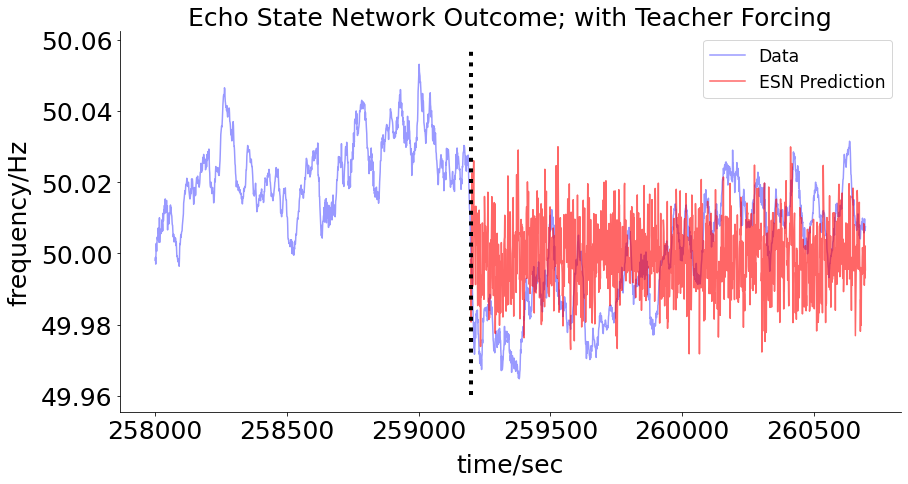

In [64]:
# plot the result
plt.figure(figsize=(14,7))
plt.plot(range(258000,trainlen+futureTotal),total_ts[258000:trainlen+futureTotal],'b', alpha=0.4, label="Data")
plt.plot(range(trainlen,trainlen+futureTotal),prediction,'r',  alpha=0.6, label='ESN Prediction')

lo,hi = plt.ylim()
plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'k:', linewidth=4)

plt.title(r'Echo State Network Outcome; with Teacher Forcing', fontsize=25)
plt.xlabel(r'time/sec', fontsize=25,labelpad=10)
plt.ylabel(r'frequency/Hz', fontsize=25,labelpad=10)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.legend(fontsize='xx-large', loc='best')
sns.despine()
plt.savefig("result_3")

In [65]:
# random network; plot the result of prediction length = 1500
rand_seed=46
spectral_radius = 0.8
noise = .005

G = nx.gnm_random_graph(511,679, seed=rand_seed) # random network

A = nx.to_numpy_array(G) # adjacency matrix of the power grid network
total_ts = np.hstack((train_ts, test_ts[:1500])) # total_ts for machine learning


esn = ESN(input_dim = 1,
      output_dim = 1, 
      adjacency_matrix = A,
      random_state=rand_seed,
      spectral_radius = spectral_radius,
      noise=noise,
      print_performance = False,
      feedback=False) # no feedback

trainlen = len(train_ts) # training data length
futureTotal = 1500 # 1500 data point prediction

pred_training = esn.fit(np.ones(trainlen),total_ts[:trainlen])
prediction = esn.predict(np.ones(futureTotal))

MSE = mean_squared_error(total_ts[trainlen:trainlen+futureTotal], prediction.flatten())
print("MSE:", MSE)
R2 = r2_score(total_ts[trainlen:trainlen+futureTotal], prediction.flatten())
print("R2:", R2)


MSE: 0.00024955847873143675
R2: -0.012434167547448416


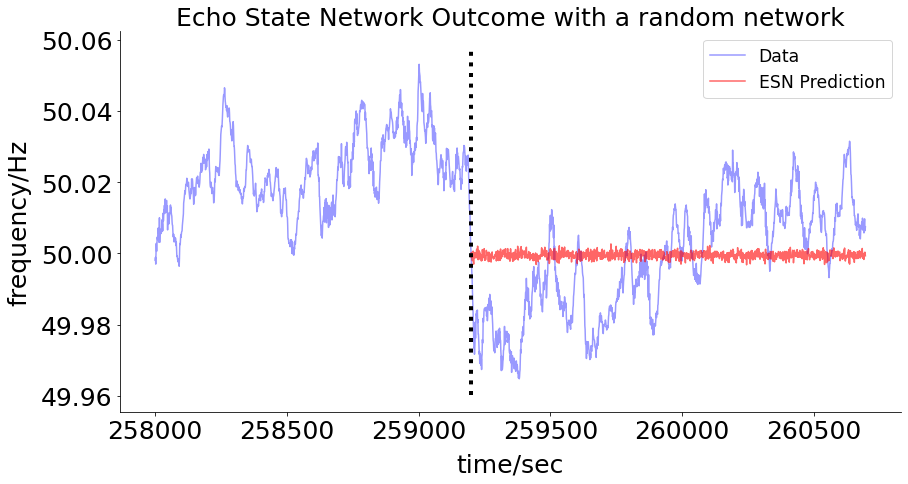

In [66]:
# plot the result
plt.figure(figsize=(14,7))
plt.plot(range(258000,trainlen+futureTotal),total_ts[258000:trainlen+futureTotal],'b', alpha=0.4, label="Data")
plt.plot(range(trainlen,trainlen+futureTotal),prediction,'r',  alpha=0.6, label='ESN Prediction')

lo,hi = plt.ylim()
plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'k:', linewidth=4)

plt.title(r'Echo State Network Outcome with a random network', fontsize=25)
plt.xlabel(r'time/sec', fontsize=25,labelpad=10)
plt.ylabel(r'frequency/Hz', fontsize=25,labelpad=10)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.legend(fontsize='xx-large', loc='best')
sns.despine()
plt.savefig("result_4")

In [67]:
# parameter optimization: noise and spectral radius

radius_list = [0.5, 0.7, 0.9, 1, 1.1, 1.3, 1.5]
noise_list = [0.0001, 0.0003,0.0007, 0.001, 0.003, 0.005, 0.007, 0.01]
radius_list_size  = len(radius_list)
noise_list_size = len(noise_list)
R2_list_3 = np.zeros([radius_list_size, noise_list_size])

In [68]:
rand_seed=46
A = nx.to_numpy_array(network) # adjacency matrix of the power grid network
total_ts = np.hstack((train_ts, test_ts[:1500])) # total_ts for machine learning
trainlen = len(train_ts) # training data length
futureTotal = 1500 # 1500 data point prediction


for i in range(radius_list_size):
    spectral_radius = radius_list[i]
    for j in range(noise_list_size):
        noise = noise_list[j]

        esn = ESN(input_dim = 1,
              output_dim = 1, 
              adjacency_matrix = A,
              random_state=rand_seed,
              spectral_radius = spectral_radius,
              noise=noise,
              print_performance = False,
              feedback=False) # no feedback


        pred_training = esn.fit(np.ones(trainlen),total_ts[:trainlen])
        prediction = esn.predict(np.ones(futureTotal))
        
        R2_list_3[i, j] = r2_score(total_ts[trainlen:trainlen+futureTotal], prediction.flatten())
        print('r = ', radius_list[i], ', noise = ', noise_list[j], ', R2 = ', R2_list_3 [i][j] )
        

r =  0.5 , noise =  0.0001 , R2 =  -0.013443934240537914
r =  0.5 , noise =  0.0003 , R2 =  -0.013492429673409578
r =  0.5 , noise =  0.0007 , R2 =  -0.013512548516838807
r =  0.5 , noise =  0.001 , R2 =  -0.013513691851008591
r =  0.5 , noise =  0.003 , R2 =  -0.01352024923399986
r =  0.5 , noise =  0.005 , R2 =  -0.01352844347292681
r =  0.5 , noise =  0.007 , R2 =  -0.013532633657040494
r =  0.5 , noise =  0.01 , R2 =  -0.013539361117584914
r =  0.7 , noise =  0.0001 , R2 =  -0.014114018605150047
r =  0.7 , noise =  0.0003 , R2 =  -0.014123737634491151
r =  0.7 , noise =  0.0007 , R2 =  -0.014159378407064604
r =  0.7 , noise =  0.001 , R2 =  -0.014174577934124466
r =  0.7 , noise =  0.003 , R2 =  -0.014195842705242878
r =  0.7 , noise =  0.005 , R2 =  -0.014199893073416847
r =  0.7 , noise =  0.007 , R2 =  -0.014203954535429109
r =  0.7 , noise =  0.01 , R2 =  -0.014208290356318543
r =  0.9 , noise =  0.0001 , R2 =  -0.0147155181010028
r =  0.9 , noise =  0.0003 , R2 =  -0.014713919

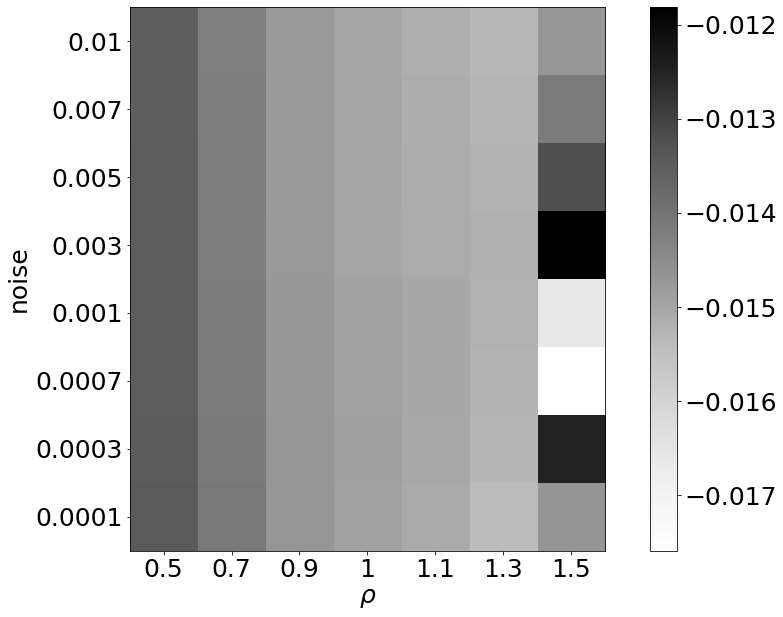

In [83]:
plt.figure(figsize=(16,10))

im = plt.imshow(R2_list_3.T, vmin=R2_list_3.min(), vmax=R2_list_3.max(), origin='lower',cmap='Greys')
plt.xticks(np.linspace(0,len(radius_list)-1,len(radius_list)), radius_list, fontsize = 25)
plt.yticks(np.linspace(0,len(noise_list)-1,len(noise_list)), noise_list, fontsize = 25)
plt.xlabel(r'$\rho$', fontsize=25)
plt.ylabel('noise', fontsize=25) 

cb = plt.colorbar(im)
cb.ax.tick_params(labelsize=25)
plt.savefig("result_5")

In [84]:
maxR2 = np.max(R2_list_3)
index_max = np.where(R2_list_3 == maxR2)
index_max
r_max = radius_list[int(index_max[0])]
noise_max = noise_list[int(index_max[1])]
print('The max R2 results from:\nspectrum radius = ',
      r_max,'\nnoise = ',noise_max,'\nR2 = ',maxR2 )

The max R2 results from:
spectrum radius =  1.5 
noise =  0.003 
R2 =  -0.011813805447002723
